In [ ]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install imblearn

In [ ]:
!nvidia-smi

Tue May 31 06:22:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   30C    P8    11W / 120W |      0MiB /  8127MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pickle
import joblib
import shutil
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from tensorflow.keras.preprocessing.text import Tokenizer

from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN
import re

## Import the cleaned data

In [ ]:
# filepath = '/content/drive/MyDrive/Assignments/Self Case Study -1 (Nepal Earthquake)/'
filepath = ''

In [ ]:
df = pd.read_csv(filepath+'df_cleaned.csv')
df.head(5)

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_asset_cable_pre_eq,has_asset_computer_pre_eq,has_asset_internet_pre_eq,has_asset_telephone_pre_eq,has_asset_mobile_phone_pre_eq,has_asset_fridge_pre_eq,has_asset_motorcycle_pre_eq,has_asset_four_wheeler_family_use_pre_eq,has_asset_four_wheeler_commercial_use_pre_eq,has_asset_none_pre_eq
0,12,1207,120703,1,9,288,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,1,0,0,0,0,0
1,12,1207,120703,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,1,0,0,0,0,0
2,12,1207,120703,1,20,384,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,1,0,0,0,0,0
3,12,1207,120703,1,20,312,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,1,0,0,0,0,0
4,12,1207,120703,1,30,308,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,1,0,0,0,0,0


## Functions

In [ ]:
def Print_Percentiles(feature, dataframe=df):
    """Prints percentile values for outlier detection"""

    print('percentile', '  value')
    for i in range(10, 101, 10):
        print(i, '         ' , np.percentile(dataframe[feature], i))
    print('-'*20)
    for i in range(1, 11, 1):
        print(90+i, '         ' , np.percentile(dataframe[feature], 90+i))
    print('-'*20)
    for i in range(1, 11, 1):
        print(99+(i/10), '       ' , np.percentile(dataframe[feature], 99+(i/10)))

def Print_Whiskers(feature, dataframe=df):
    """Prints low and high fences of boxplot wherein below low and above high values are outliers"""

    q3 = np.percentile(dataframe[feature], 75)
    q1 = np.percentile(dataframe[feature], 25)
    iqr = q3-q1

    clip_low = max(q1 - (1.5*iqr),0)
    clip_high = q3 + (1.5*iqr)

    print('Lower Whisker: ', clip_low)
    print('Higher Whisker: ', clip_high)

In [ ]:
def preprocess_text(text):
    ''' This function preprocesses the categorical text feature '''

    text = str(text).lower()
    text = re.sub(r'\.', '', text)
    text = re.sub(r' |/|-', '_', text)   # Replace space or '/' or '-' chars by '_'
    return text

def Label_Encode(feature, train_data, test_data, return_tokens_mapping = False):
    '''This function encodes cateogorical variable and handles out of vocabulary words'''

    tokens_mapping = {}
    tokenizer = Tokenizer(filters='', oov_token='unk')
    tokenizer.fit_on_texts(train_data[feature])
    train_data[feature] = np.array(tokenizer.texts_to_sequences(train_data[feature])).ravel()
    test_data[feature] = np.array(tokenizer.texts_to_sequences(test_data[feature])).ravel()
    tokens_mapping[feature] = tokenizer.word_index

    if not os.path.exists(filepath+'tokenizers'):
        os.makedirs(filepath+'tokenizers')
    joblib.dump(tokenizer, filepath+'tokenizers/'+feature+'_tokenizer.pkl')

    if return_tokens_mapping:
        return tokens_mapping

def Clip_Feature(feature, min_percentile, max_percentile):

    clip_min = np.percentile(feature, min_percentile)
    clip_max = np.percentile(feature, max_percentile)
    num_points_clipped = (feature < clip_min).sum() + (feature > clip_max).sum()

    joblib.dump((clip_min, clip_max), filepath+'mapping_dictionaries/'+ feature.name+'.pkl')
    print('Number of points clipped:', num_points_clipped)

    return clip_min, clip_max

In [ ]:
def plot_confusion_matrix(y_actual, y_predicted):
    ''' This function will plot the precision and recall matrix along with confusion matrix'''

    C = confusion_matrix(y_actual, y_predicted)

    recall_matrix = (C.T / C.sum(axis=1)).T  # Row sum = 1

    precision_matrix = C / C.sum(axis=0)   # col sum = 1

    plt.figure(figsize=(28,6), )
    labels = ['Mild', 'Moderate', 'Severe']
    plt.subplot(1,3,1)
    sns.heatmap(C, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(recall_matrix, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Recall matrix')

    plt.subplot(1,3,3)
    sns.heatmap(precision_matrix, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Precision matrix')

    plt.show()

def print_classification_report(y_true, y_predicted):
    '''This function prints the report of classification metrics'''
    print(classification_report(y_true, y_predicted, target_names=['mild', 'moderate', 'severe']))


def plot_results(y_train, train_results=True, test_results=True):
    '''This function plots the confusion matrix and prints classification report on train and test data'''

    if train_results:
        print('\033[1mConfusion matrix on train data\033[0m')
        plot_confusion_matrix(y_train, y_tr_pred)
    if test_results:
        print('\n\033[1mConfusion matrix on test data\033[0m')
        plot_confusion_matrix(y_test, y_te_pred)
    if train_results:
        print('\n\033[1mClassification report on train data\033[0m')
        print_classification_report(y_train, y_tr_pred)
    if test_results:
        print('\n\033[1mClassification report on test data\033[0m')
        print_classification_report(y_test, y_te_pred)

In [ ]:
def get_embedding_matrix(model):

    embedding_matrix = []
    for layer in model.layers:
        if 'Embedding' in str(layer):
            embedding_matrix.append(layer.get_weights()[0])

    embedding_dict = dict(zip(cat_feat, embedding_matrix))

    return embedding_dict

def get_embedded_data(embedding_matrix, train_data, test_data):

    train_embed, test_embed = [], []
    for feat in list(embedding_matrix.keys()):
        train_embed.append(embedding_matrix[feat][np.round(train_data[feat]).astype(int)])
        test_embed.append(embedding_matrix[feat][test_data[feat]])

    train_embed = pd.DataFrame(np.concatenate(train_embed, axis=1), columns = cat_embed_names)
    test_embed = pd.DataFrame(np.concatenate(test_embed, axis=1), columns = cat_embed_names)

    train_embed = pd.concat((train_embed, train_data[num_feat]), axis=1)
    test_embed = pd.concat((test_embed, test_data[num_feat]), axis=1)

    return train_embed, test_embed

## Train-test split

In [ ]:
X = df.drop(['severity_of_damage'], axis=1)
y = df['severity_of_damage']

In [ ]:
print('Number of points in each category: \n', y.value_counts())

Number of points in each category: 
 Severe      457728
Mild        157228
Moderate    132168
Name: severity_of_damage, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=15)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('Shape of training data: ', X_train.shape, y_train.shape)
print('Shape of test data: ', X_test.shape, y_test.shape)

Shape of training data:  (635055, 61) (635055,)
Shape of test data:  (112069, 61) (112069,)


In [ ]:
joblib.dump([X_test, y_test], filepath+'test_data/test_data.pkl')

['test_data/test_data.pkl']

## Preprocessing

In [ ]:
# converting numeric ids to object dtypes
X_train[['district_id', 'vdcmun_id', 'ward_id']] = X_train[['district_id', 'vdcmun_id', 'ward_id']].astype(str)
X_test[['district_id', 'vdcmun_id', 'ward_id']] = X_test[['district_id', 'vdcmun_id', 'ward_id']].astype(str)

In [ ]:
# separating categorical and numerical features
cat_feat = list(X_train.select_dtypes('object').columns)
num_feat = list(X_train.select_dtypes('int').columns)

joblib.dump(cat_feat, filepath+'cat_feat.pkl')
joblib.dump(num_feat, filepath+'num_feat.pkl')

['num_feat.pkl']

### 1. Target variable: 'severity_of_damage'

In [ ]:
print('Unique values:', sorted(y_train.unique()))

Unique values: ['Mild', 'Moderate', 'Severe']


In [ ]:
target_mapping = {'Mild': 0, 'Moderate': 1, 'Severe': 2}

y_train = y_train.map(target_mapping)
y_test = y_test.map(target_mapping)

### 2. Numerical features

In [ ]:
# Selecting the numerical features to preprocess

num_preprocessing_feat = []
for feat in num_feat:
    if 'has_' not in feat:
        if 'is_bank' not in feat:
            if 'count_' not in feat:
                num_preprocessing_feat.append(feat)

num_preprocessing_feat

['age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'age_household_head',
 'size_household']

#### Feature 'age_building'

In [ ]:
Print_Percentiles('age_building')
print('\nWhiskers from boxplot:')
Print_Whiskers('age_building')

percentile   value
10           4.0
20           7.0
30           10.0
40           14.0
50           16.0
60           20.0
70           25.0
80           30.0
90           40.0
100           999.0
--------------------
91           44.0
92           45.0
93           50.0
94           50.0
95           54.0
96           60.0
97           65.0
98           79.0
99           90.0
100           999.0
--------------------
99.1         98.0
99.2         100.0
99.3         100.0
99.4         100.0
99.5         125.0
99.6         999.0
99.7         999.0
99.8         999.0
99.9         999.0
100.0         999.0

Whiskers from boxplot:
Lower Whisker:  0
Higher Whisker:  54.0


In [ ]:
num_points_removed = (X_train.age_building > np.percentile(X_train.age_building, 99.5)).sum()
X_train = X_train[X_train.age_building <= np.percentile(X_train.age_building, 99.5)]
y_train = y_train[X_train.index]

print('Number of points removed:', num_points_removed)

Number of points removed: 3162


In [ ]:
# clip_min, clip_max = X_train.age_building.min(), 100

# X_train['age_building'] = np.clip(X_train['age_building'], a_min=clip_min, a_max=clip_max)
# X_test['age_building'] = np.clip(X_test['age_building'], a_min=clip_min, a_max=clip_max)

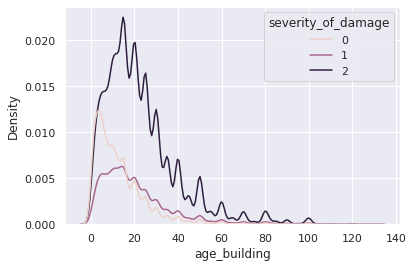

In [ ]:
sns.kdeplot(X_train['age_building'], hue=y_train)
plt.show()

In [ ]:
print('Skewness in the feature age_building: ', X_train.age_building.skew())

Skewness in the feature age_building:  1.756478590618146


Lets apply feature transformations like log and box_cox to reduce skewness and select the best

In [ ]:
log_age_building = np.log(X_train.age_building + 1)         # plus 1 as log(0) is not defined
boxcox_age_building, lambda_age_building = stats.boxcox(X_train['age_building']+1)       # plus 1 as log(0) is not defined

print('Skewness in the feature age_building after log transformation    :', pd.Series(log_age_building).skew())
print('Skewness in the feature age_building after box_cox transformation:', pd.Series(boxcox_age_building).skew())

Skewness in the feature age_building after log transformation    : -0.5518374532495095
Skewness in the feature age_building after box_cox transformation: -0.011739783178137134


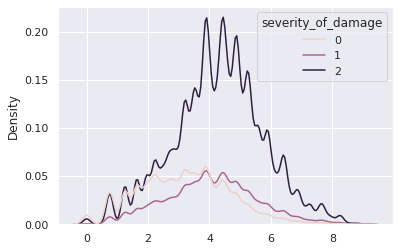

In [ ]:
sns.kdeplot(boxcox_age_building, hue=y_train)
plt.show()

In [ ]:
X_train['age_building'] = boxcox_age_building
X_test['age_building'] = stats.boxcox(X_test['age_building']+1, lambda_age_building)

#### Feature 'plinth_area_sq_ft'

In [ ]:
Print_Percentiles('plinth_area_sq_ft')
print('\nWhiskers from boxplot:')
Print_Whiskers('plinth_area_sq_ft')

percentile   value
10           216.0
20           264.0
30           300.0
40           325.0
50           360.0
60           400.0
70           450.0
80           525.0
90           660.0
100           5000.0
--------------------
91           690.0
92           720.0
93           750.0
94           792.0
95           832.0
96           900.0
97           960.0
98           1066.0
99           1286.0
100           5000.0
--------------------
99.1         1326.0
99.2         1370.0
99.3         1423.0
99.4         1500.0
99.5         1575.0
99.6         1680.0
99.7         1822.0
99.8         2000.0
99.9         2400.0
100.0         5000.0

Whiskers from boxplot:
Lower Whisker:  0
Higher Whisker:  790.0


In [ ]:
num_points_removed = (X_train.plinth_area_sq_ft > np.percentile(X_train.plinth_area_sq_ft, 99.9)).sum()
X_train = X_train[X_train.plinth_area_sq_ft <= np.percentile(X_train.plinth_area_sq_ft, 99.9)]
y_train = y_train[X_train.index]

print('Number of points removed:', num_points_removed)

Number of points removed: 627


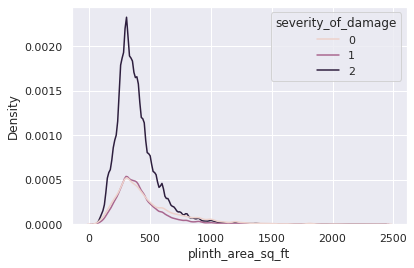

In [ ]:
sns.kdeplot(X_train['plinth_area_sq_ft'], hue=y_train)
plt.show()

In [ ]:
print('Skewness in the feature plinth_area_sq_ft: ', X_train.plinth_area_sq_ft.skew())

Skewness in the feature plinth_area_sq_ft:  2.462280836282764


Lets apply feature transformations like log and box_cox to reduce skewness and select the best

In [ ]:
log_plinth_area_sq_ft = np.log(X_train.plinth_area_sq_ft+1)
boxcox_plinth_area_sq_ft, lambda_plinth_area_sq_ft = stats.boxcox(X_train['plinth_area_sq_ft']+1)

print('Skewness in the feature plinth_area_sq_ft after log transformation    :', pd.Series(log_plinth_area_sq_ft).skew())
print('Skewness in the feature plinth_area_sq_ft after boxcox transformation:', pd.Series(boxcox_plinth_area_sq_ft).skew())

Skewness in the feature plinth_area_sq_ft after log transformation    : 0.24172143908585444
Skewness in the feature plinth_area_sq_ft after boxcox transformation: -0.014832687112718021


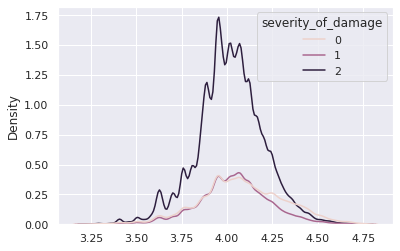

In [ ]:
sns.kdeplot(boxcox_plinth_area_sq_ft, hue= y_train)
plt.show()

In [ ]:
X_train['plinth_area_sq_ft'] = boxcox_plinth_area_sq_ft
X_test['plinth_area_sq_ft'] = stats.boxcox(X_test['plinth_area_sq_ft']+1, lambda_plinth_area_sq_ft)

#### Feature 'height_ft_pre_eq'

In [ ]:
Print_Percentiles('height_ft_pre_eq')
print('\nWhiskers from boxplot:')
Print_Whiskers('height_ft_pre_eq')

percentile   value
10           10.0
20           12.0
30           14.0
40           15.0
50           16.0
60           17.0
70           18.0
80           20.0
90           22.0
100           99.0
--------------------
91           22.0
92           23.0
93           24.0
94           24.0
95           25.0
96           25.0
97           27.0
98           29.0
99           32.0
100           99.0
--------------------
99.1         33.0
99.2         35.0
99.3         36.0
99.4         36.0
99.5         36.0
99.6         40.0
99.7         40.0
99.8         45.0
99.9         50.0
100.0         99.0

Whiskers from boxplot:
Lower Whisker:  5.5
Higher Whisker:  25.5


In [ ]:
num_points_removed = (X_train.height_ft_pre_eq > np.percentile(X_train.height_ft_pre_eq, 99.9)).sum()
X_train = X_train[X_train.height_ft_pre_eq <= np.percentile(X_train.height_ft_pre_eq, 99.9)]
y_train = y_train[X_train.index]

print('Number of points removed:', num_points_removed)

Number of points removed: 584


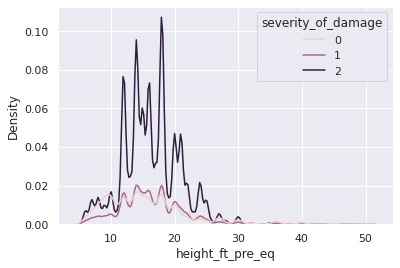

In [ ]:
sns.kdeplot(X_train['height_ft_pre_eq'], hue=y_train)
plt.show()

In [ ]:
print('Skewness in the feature height_ft_pre_eq: ', X_train.height_ft_pre_eq.skew())

Skewness in the feature height_ft_pre_eq:  0.9845249551188344


Lets apply feature transformations like log and box_cox to reduce skewness and select the best

In [ ]:
log_height_ft_pre_eq = np.log(X_train.height_ft_pre_eq+1)
boxcox_height_ft_pre_eq, lambda_height_ft_pre_eq = stats.boxcox(X_train['height_ft_pre_eq']+1)

print('Skewness in the feature height_ft_pre_eq after log transformation    :', pd.Series(log_height_ft_pre_eq).skew())
print('Skewness in the feature height_ft_pre_eq after boxcox transformation:', pd.Series(boxcox_height_ft_pre_eq).skew())

Skewness in the feature height_ft_pre_eq after log transformation    : -0.32724549800059816
Skewness in the feature height_ft_pre_eq after boxcox transformation: 0.019355453255086308


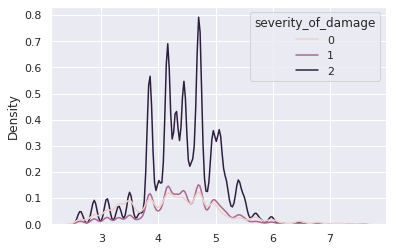

In [ ]:
sns.kdeplot(boxcox_height_ft_pre_eq, hue= y_train)
plt.show()

In [ ]:
X_train['height_ft_pre_eq'] = boxcox_height_ft_pre_eq
X_test['height_ft_pre_eq'] = stats.boxcox(X_test['height_ft_pre_eq']+1, lambda_height_ft_pre_eq)

#### Feature 'age_household_head'

In [ ]:
Print_Percentiles('age_household_head')
print('\nWhiskers from boxplot:')
Print_Whiskers('age_household_head')

percentile   value
10           28.0
20           32.0
30           37.0
40           41.0
50           46.0
60           50.0
70           55.0
80           60.0
90           67.0
100           122.0
--------------------
91           68.0
92           70.0
93           71.0
94           72.0
95           73.0
96           75.0
97           76.0
98           79.0
99           82.0
100           122.0
--------------------
99.1         83.0
99.2         83.0
99.3         84.0
99.4         85.0
99.5         85.0
99.6         86.0
99.7         87.0
99.8         89.0
99.9         92.0
100.0         122.0

Whiskers from boxplot:
Lower Whisker:  0
Higher Whisker:  91.5


In [ ]:
num_points_removed = (X_train.age_household_head > np.percentile(X_train.age_household_head, 99.9)).sum()
X_train = X_train[X_train.age_household_head <= np.percentile(X_train.age_household_head, 99.9)]
y_train = y_train[X_train.index]

print('Number of points removed:', num_points_removed)

Number of points removed: 605


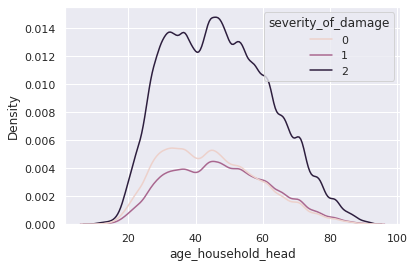

In [ ]:
sns.kdeplot(X_train.age_household_head, hue=y_train)
plt.show()

In [ ]:
print('Skewness in the feature age_household_head: ', X_train.age_household_head.skew())

Skewness in the feature age_household_head:  0.3171702937557162


Lets apply feature transformations like log and box_cox to reduce skewness and select the best

In [ ]:
log_age_household_head = np.log(X_train.age_household_head+1)
boxcox_age_household_head, lambda_age_household_head = stats.boxcox(X_train['age_household_head']+1)

print('Skewness in the feature age_household_head after log transformation    :', pd.Series(log_age_household_head).skew())
print('Skewness in the feature age_household_head after boxcox transformation:', pd.Series(boxcox_age_household_head).skew())

Skewness in the feature age_household_head after log transformation    : -0.33903888871031906
Skewness in the feature age_household_head after boxcox transformation: -0.03319012092273169


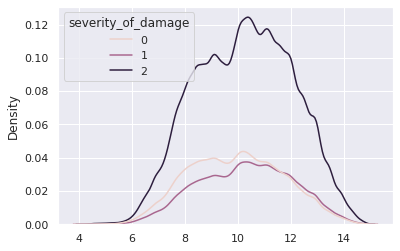

In [ ]:
sns.kdeplot(boxcox_age_household_head, hue=y_train)
plt.show()

In [ ]:
X_train['age_household_head'] = boxcox_age_household_head
X_test['age_household_head'] = stats.boxcox(X_test['age_household_head']+1, lambda_age_household_head)

#### Feature 'size_household'

In [ ]:
Print_Percentiles('size_household')
print('\nWhiskers from boxplot:')
Print_Whiskers('size_household')

percentile   value
10           2.0
20           3.0
30           4.0
40           4.0
50           5.0
60           5.0
70           6.0
80           6.0
90           8.0
100           40.0
--------------------
91           8.0
92           8.0
93           9.0
94           9.0
95           9.0
96           10.0
97           10.0
98           11.0
99           13.0
100           40.0
--------------------
99.1         13.0
99.2         14.0
99.3         14.0
99.4         14.0
99.5         15.0
99.6         15.0
99.7         16.0
99.8         17.0
99.9         19.0
100.0         40.0

Whiskers from boxplot:
Lower Whisker:  0
Higher Whisker:  10.5


In [ ]:
num_points_removed = (X_train.size_household > np.percentile(X_train.size_household, 99.9)).sum()
X_train = X_train[X_train.size_household <= np.percentile(X_train.size_household, 99.9)]
y_train = y_train[X_train.index]

print('Number of points removed:', num_points_removed)

Number of points removed: 521


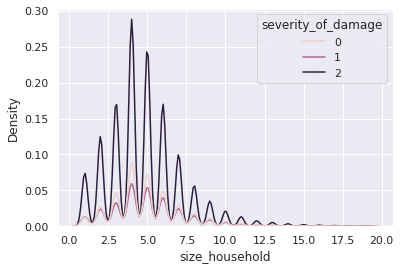

In [ ]:
sns.kdeplot(X_train.size_household, hue=y_train)
plt.show()

In [ ]:
print('Skewness in the feature size_household: ', X_train.size_household.skew())

Skewness in the feature size_household:  1.1854619317843604


Lets apply feature transformations like log and box_cox to reduce skewness and select the best

In [ ]:
log_size_household = np.log(X_train.size_household+1)
boxcox_size_household, lambda_size_household = stats.boxcox(X_train['size_household']+1)

print('Skewness in the feature size_household after log transformation    :', pd.Series(log_size_household).skew())
print('Skewness in the feature size_household after boxcox transformation:', pd.Series(boxcox_size_household).skew())

Skewness in the feature size_household after log transformation    : -0.33499753161781476
Skewness in the feature size_household after boxcox transformation: 0.01045832994331322


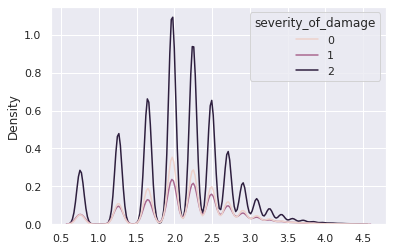

In [ ]:
sns.kdeplot(boxcox_size_household, hue=y_train)
plt.show()

In [ ]:
X_train['size_household'] = boxcox_size_household
X_test['size_household'] = stats.boxcox(X_test['size_household']+1, lambda_size_household)

#### Exporting boxcox fitted lambda values

In [ ]:
boxcox_fit_lambdas = {'lambda_age_building': lambda_age_building, 'lambda_plinth_area_sq_ft': lambda_plinth_area_sq_ft,
                         'lambda_height_ft_pre_eq': lambda_height_ft_pre_eq, 'lambda_age_household_head': lambda_age_household_head,
                         'lambda_size_household': lambda_size_household}

joblib.dump(boxcox_fit_lambdas, filepath+'boxcox_fit_lambdas.pkl')

boxcox_fit_lambdas

{'lambda_age_building': 0.23178539778547055,
 'lambda_plinth_area_sq_ft': -0.13852972205660755,
 'lambda_height_ft_pre_eq': 0.2973853871779487,
 'lambda_age_household_head': 0.4479337069519943,
 'lambda_size_household': 0.24386619559513253}

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

### 3. Categorical Features

#### Preprocess text

In [ ]:
%%time
for feature in tqdm(cat_feat):
    X_train[feature] = X_train[feature].apply(preprocess_text)
    X_test[feature] = X_test[feature].apply(preprocess_text)
    Label_Encode(feature, X_train, X_test)

100%|██████████| 19/19 [05:31<00:00, 17.46s/it]

CPU times: user 5min 12s, sys: 1.87 s, total: 5min 14s
Wall time: 5min 31s


### Handling Imbalanced data

#### Oversampling

In [ ]:
%%time
# https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

X_train_columns = X_train.columns
oversampling = SMOTE(random_state=42, n_jobs=-1)
X_tr_oversamp, y_tr_oversamp = oversampling.fit_resample(X_train, y_train)
X_tr_oversamp = pd.DataFrame(X_tr_oversamp, columns=X_train_columns)
y_tr_oversamp = pd.DataFrame(y_tr_oversamp)

joblib.dump([X_tr_oversamp, y_tr_oversamp], filepath+'oversamp/oversampled.pkl')

print('value counts of oversampled train data:')
print(y_tr_oversamp.value_counts())

value counts of oversampled train data:
severity_of_damage
0                     385931
1                     385931
2                     385931
dtype: int64


#### Undersampling

In [ ]:
%%time
#https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
from imblearn.under_sampling import TomekLinks

X_train_columns = X_train.columns
undersampling = TomekLinks(sampling_strategy='majority', n_jobs=-1)
X_tr_undersamp, y_tr_undersamp = undersampling.fit_resample(X_train, y_train)
X_tr_undersamp = pd.DataFrame(X_tr_undersamp, columns=X_train_columns)
y_tr_undersamp = pd.DataFrame(y_tr_undersamp)

joblib.dump([X_tr_undersamp, y_tr_undersamp], filepath+'undersamp/undersampled.pkl')

print('value counts of undersampled train data:')
print(y_tr_undersamp.value_counts())

#### Combined sampling

In [ ]:
%%time
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

X_train_columns = X_train.columns
combsampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), n_jobs=-1, random_state=42)
X_tr_combsamp, y_tr_combsamp = combsampling.fit_resample(X_train, y_train)
X_tr_combsamp = pd.DataFrame(X_tr_combsamp, columns=X_train_columns)
y_tr_combsamp = pd.DataFrame(y_tr_combsamp)

joblib.dump([X_tr_combsamp, y_tr_combsamp], filepath+'combsamp/combsampled.pkl')

print('value counts of combined sampled train data:')
print(y_tr_combsamp.value_counts())

### Entity Embedding

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, BatchNormalization, Reshape, Concatenate
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import backend as K

In [ ]:
# https://www.kaggle.com/abhishek/same-old-entity-embeddings

def create_embedding_model(data, cat_cols=None, num_cols=None):
    inputs = []
    outputs = []
    cat_embed_names = []

    # categorical input features
    if cat_cols is not None:
        for feat in cat_cols:
            nuniques = data[feat].nunique()
            # https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras
            embed_dim = int(np.ceil(min(nuniques/2, 50)))
            for i in range(embed_dim):
                cat_embed_names.append(feat+'_'+str(i))
            inp = Input(shape=(1,))
            out = Embedding(nuniques+2, embed_dim, name=feat)(inp)
            out = Reshape(target_shape=(embed_dim,))(out)
            inputs.append(inp)
            outputs.append(out)

    # Numerical input features
    # if num_cols is not None:
    inp = Input(shape=(len(num_feat),))
    inputs.append(inp)
    outputs.append(inp)

    x = Concatenate(axis=-1)(outputs)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    y = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    return model, cat_embed_names

In [ ]:
# Summary of model
tf.keras.backend.clear_session()
model, cat_embed_names = create_embedding_model(X_train, cat_feat, num_feat)
joblib.dump(cat_embed_names, filepath+'cat_embed_names.pkl')
model.summary()

2022-05-31 06:30:31.707854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 06:30:32.219186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 06:30:32.220384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 06:30:32.228965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 06:30:32.230332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True, min_delta=1e-4)
plateau = ReduceLROnPlateau(monitor='val_auc', patience=1, factor= 0.1, mode='max', min_delta=1e-4)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, train_data, validation_data):
        self.train_data = train_data
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        # Initiating history log
        self.history = {'micro_F1': [], 'val_micro_F1': []}

    def on_epoch_end(self, epoch, logs={}):
        X_train, y_train = self.train_data[0], self.train_data[1]
        X_val, y_val = self.validation_data[0], self.validation_data[1]

        train_pred = np.argmax(np.asarray(self.model.predict(X_train)), axis=1)          # model prediction on train data
        val_pred = np.argmax(np.asarray(self.model.predict(X_val)), axis=1)               # model prediction on test data

        train_f1 = f1_score(y_train, train_pred.round(), average = 'micro')   # Micro_f1 score on train data
        val_f1 = f1_score(y_test, val_pred.round(), average='micro')           # Micro_f1 score on cv data

        # Appending log
        self.history['micro_F1'].append(train_f1)
        self.history['val_micro_F1'].append(val_f1)

        print("                                         - micro_f1: {} - val_micro_f1: {}".format(np.round(train_f1,4), np.round(val_f1,4)))


# https://keras.io/api/callbacks/model_checkpoint/#:~:text=Callback%20to%20save%20the%20Keras,training%20from%20the%20state%20saved.
checkpoint_path = filepath +'models/model_ckpt/combsamp/model_weights-{epoch:02d}-{val_auc:.4f}.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_weights_only=False,
    save_best_only=False)

#### Train Embedding model on oversampled data

In [ ]:
# shutil.rmtree(filepath+'models/model_ckpt/undersamp')

In [ ]:
# Data Selection
X_tr_oversamp, y_tr_oversamp = joblib.load(filepath+'oversamp/oversampled.pkl')

y_tr_oversamp.value_counts()

severity_of_damage
0                     385931
1                     385931
2                     385931
dtype: int64

In [ ]:
X_tr_inputs = []
for col in cat_feat:
    X_tr_inputs.append(X_tr_oversamp[col].values)
X_tr_inputs.append(X_tr_oversamp[num_feat].values)

X_te_inputs = []
for col in cat_feat:
    X_te_inputs.append(X_test[col].values)
X_te_inputs.append(X_test[num_feat].values)

metrics = Metrics([X_tr_inputs, y_tr_oversamp], [X_te_inputs, y_test])

tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_oversamp), epochs=30, batch_size=512,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

2022-02-26 11:25:22.090448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
2036/2036 [==============================] - 37s 17ms/step - loss: 0.6780 - accuracy: 0.6985 - auc: 0.8732 - val_loss: 0.9195 - val_accuracy: 0.4995 - val_auc: 0.7271
                                         - micro_f1: 0.6955 - val_micro_f1: 0.7247
Epoch 2/30
2036/2036 [==============================] - 32s 16ms/step - loss: 0.6409 - accuracy: 0.7165 - auc: 0.8870 - val_loss: 0.9254 - val_accuracy: 0.5092 - val_auc: 0.7245
                                         - micro_f1: 0.7062 - val_micro_f1: 0.7334
Epoch 3/30
2036/2036 [==============================] - 33s 16ms/step - loss: 0.6164 - accuracy: 0.7285 - auc: 0.8955 - val_loss: 0.9032 - val_accuracy: 0.5279 - val_auc: 0.7421
                                         - micro_f1: 0.7141 - val_micro_f1: 0.7338
Epoch 4/30
2036/2036 [==============================] - 32s 16ms/step - loss: 0.6104 - accuracy: 0.7314 - auc: 0.8975 - val_loss: 0.8688 - val_accuracy: 0.5524 - val_auc: 0.7607
                                       

In [ ]:
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_oversamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
8141/8141 [==============================] - 128s 16ms/step - loss: 0.5997 - accuracy: 0.7369 - auc: 0.9011 - val_loss: 0.8614 - val_accuracy: 0.5558 - val_auc: 0.7646
                                         - micro_f1: 0.7232 - val_micro_f1: 0.738
Epoch 2/30
8141/8141 [==============================] - 129s 16ms/step - loss: 0.6000 - accuracy: 0.7364 - auc: 0.9009 - val_loss: 0.8637 - val_accuracy: 0.5546 - val_auc: 0.7634
                                         - micro_f1: 0.7231 - val_micro_f1: 0.7382
Epoch 3/30
8141/8141 [==============================] - 128s 16ms/step - loss: 0.5998 - accuracy: 0.7366 - auc: 0.9010 - val_loss: 0.8639 - val_accuracy: 0.5544 - val_auc: 0.7633
                                         - micro_f1: 0.7231 - val_micro_f1: 0.7382
Epoch 4/30
8141/8141 [==============================] - 131s 16ms/step - loss: 0.5996 - accuracy: 0.7368 - auc: 0.9011 - val_loss: 0.8639 - val_accuracy: 0.5544 - val_auc: 0.7633
                                    

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_oversamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
8141/8141 [==============================] - 130s 16ms/step - loss: 0.6331 - accuracy: 0.7218 - auc: 0.8900 - val_loss: 0.9484 - val_accuracy: 0.5225 - val_auc: 0.7261
                                         - micro_f1: 0.7128 - val_micro_f1: 0.7399
Epoch 2/30
8141/8141 [==============================] - 130s 16ms/step - loss: 0.6227 - accuracy: 0.7268 - auc: 0.8938 - val_loss: 0.8494 - val_accuracy: 0.5627 - val_auc: 0.7720
                                         - micro_f1: 0.7217 - val_micro_f1: 0.7354
Epoch 3/30
8141/8141 [==============================] - 130s 16ms/step - loss: 0.6135 - accuracy: 0.7316 - auc: 0.8970 - val_loss: 0.8918 - val_accuracy: 0.5364 - val_auc: 0.7478
                                         - micro_f1: 0.7238 - val_micro_f1: 0.7369
Epoch 4/30
8141/8141 [==============================] - 129s 16ms/step - loss: 0.5875 - accuracy: 0.7427 - auc: 0.9053 - val_loss: 0.8368 - val_accuracy: 0.5618 - val_auc: 0.7751
                                   

Observation: We see that the best training score and test score achieved on oversampled data is 0.7425 and 0.7445 (8th epoch)

#### Train Embedding model on undersampled data

In [ ]:
# shutil.rmtree(filepath+'models/model_ckpt/undersamp')

In [ ]:
X_tr_undersamp, y_tr_undersamp = joblib.load(filepath+'undersamp/undersampled.pkl')

y_tr_undersamp.value_counts()

severity_of_damage
2                     359325
0                     132234
1                     111391
dtype: int64

In [ ]:
X_tr_inputs = []
for col in cat_feat:
    X_tr_inputs.append(X_tr_undersamp[col].values)
X_tr_inputs.append(X_tr_undersamp[num_feat].values)

X_te_inputs = []
for col in cat_feat:
    X_te_inputs.append(X_test[col].values)
X_te_inputs.append(X_test[num_feat].values)

metrics = Metrics([X_tr_inputs, y_tr_undersamp], [X_te_inputs, y_test])

tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_undersamp), epochs=30, batch_size=512,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
1060/1060 [==============================] - 21s 18ms/step - loss: 0.6116 - accuracy: 0.7408 - auc: 0.8994 - val_loss: 0.5758 - val_accuracy: 0.7552 - val_auc: 0.9107
                                         - micro_f1: 0.756 - val_micro_f1: 0.7479
Epoch 2/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5792 - accuracy: 0.7545 - auc: 0.9098 - val_loss: 0.5720 - val_accuracy: 0.7565 - val_auc: 0.9122
                                         - micro_f1: 0.7581 - val_micro_f1: 0.7478
Epoch 3/30
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5729 - accuracy: 0.7575 - auc: 0.9117 - val_loss: 0.5657 - val_accuracy: 0.7595 - val_auc: 0.9140
                                         - micro_f1: 0.761 - val_micro_f1: 0.7556
Epoch 4/30
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5664 - accuracy: 0.7598 - auc: 0.9138 - val_loss: 0.5574 - val_accuracy: 0.7629 - val_auc: 0.9168
                                         

In [ ]:
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_undersamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
4240/4240 [==============================] - 69s 16ms/step - loss: 0.5211 - accuracy: 0.7787 - auc: 0.9268 - val_loss: 0.5319 - val_accuracy: 0.7751 - val_auc: 0.9239
                                         - micro_f1: 0.7827 - val_micro_f1: 0.7666
Epoch 2/30
4240/4240 [==============================] - 68s 16ms/step - loss: 0.5212 - accuracy: 0.7792 - auc: 0.9268 - val_loss: 0.5319 - val_accuracy: 0.7751 - val_auc: 0.9239
                                         - micro_f1: 0.7827 - val_micro_f1: 0.7666
Epoch 3/30
4240/4240 [==============================] - 68s 16ms/step - loss: 0.5215 - accuracy: 0.7784 - auc: 0.9267 - val_loss: 0.5319 - val_accuracy: 0.7751 - val_auc: 0.9239
                                         - micro_f1: 0.7827 - val_micro_f1: 0.7666
Epoch 4/30
4240/4240 [==============================] - 70s 17ms/step - loss: 0.5215 - accuracy: 0.7790 - auc: 0.9267 - val_loss: 0.5319 - val_accuracy: 0.7751 - val_auc: 0.9239
                                       

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_undersamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
4240/4240 [==============================] - 69s 16ms/step - loss: 0.5517 - accuracy: 0.7667 - auc: 0.9183 - val_loss: 0.5478 - val_accuracy: 0.7667 - val_auc: 0.9197
                                         - micro_f1: 0.7727 - val_micro_f1: 0.7624
Epoch 2/30
4240/4240 [==============================] - 68s 16ms/step - loss: 0.5503 - accuracy: 0.7676 - auc: 0.9188 - val_loss: 0.5420 - val_accuracy: 0.7694 - val_auc: 0.9214
                                         - micro_f1: 0.7749 - val_micro_f1: 0.7633
Epoch 3/30
4240/4240 [==============================] - 69s 16ms/step - loss: 0.5475 - accuracy: 0.7685 - auc: 0.9196 - val_loss: 0.5492 - val_accuracy: 0.7701 - val_auc: 0.9214
                                         - micro_f1: 0.7762 - val_micro_f1: 0.7643
Epoch 4/30
4240/4240 [==============================] - 69s 16ms/step - loss: 0.5284 - accuracy: 0.7757 - auc: 0.9248 - val_loss: 0.5333 - val_accuracy: 0.7738 - val_auc: 0.9239
                                       

Observation: We see that the best training score and test score achieved on undersampled data is 0.787 and 0.769 (13th epoch)

#### Train Embedding model on undersampled and oversampled data (combined) sampled

In [ ]:
# shutil.rmtree(filepath+'models/model_ckpt/combsamp')

In [ ]:
X_tr_combsamp, y_tr_combsamp = joblib.load(filepath+'combsamp/combsampled.pkl')

y_tr_combsamp.value_counts()

severity_of_damage
1                     385931
2                     385931
0                     384299
dtype: int64

In [ ]:
X_tr_inputs = []
for col in cat_feat:
    X_tr_inputs.append(X_tr_combsamp[col].values)
X_tr_inputs.append(X_tr_combsamp[num_feat].values)

X_te_inputs = []
for col in cat_feat:
    X_te_inputs.append(X_test[col].values)
X_te_inputs.append(X_test[num_feat].values)

metrics = Metrics([X_tr_inputs, y_tr_combsamp], [X_te_inputs, y_test])

tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_combsamp), epochs=30, batch_size=512,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
2033/2033 [==============================] - 38s 18ms/step - loss: 0.6759 - accuracy: 0.6992 - auc: 0.8740 - val_loss: 0.8859 - val_accuracy: 0.5463 - val_auc: 0.7532
                                         - micro_f1: 0.7006 - val_micro_f1: 0.7203
Epoch 2/30
2033/2033 [==============================] - 36s 18ms/step - loss: 0.6381 - accuracy: 0.7179 - auc: 0.8879 - val_loss: 0.9413 - val_accuracy: 0.5082 - val_auc: 0.7201
                                         - micro_f1: 0.7062 - val_micro_f1: 0.7345
Epoch 3/30
2033/2033 [==============================] - 37s 18ms/step - loss: 0.6144 - accuracy: 0.7287 - auc: 0.8960 - val_loss: 0.9031 - val_accuracy: 0.5276 - val_auc: 0.7412
                                         - micro_f1: 0.7148 - val_micro_f1: 0.7375
Epoch 4/30
2033/2033 [==============================] - 31s 15ms/step - loss: 0.6087 - accuracy: 0.7315 - auc: 0.8980 - val_loss: 0.8846 - val_accuracy: 0.5411 - val_auc: 0.7518
                                       

In [ ]:
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_combsamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
8130/8130 [==============================] - 140s 17ms/step - loss: 0.6412 - accuracy: 0.7156 - auc: 0.8866 - val_loss: 0.9422 - val_accuracy: 0.4989 - val_auc: 0.7176
                                         - micro_f1: 0.6967 - val_micro_f1: 0.7255
Epoch 2/30
8130/8130 [==============================] - 133s 16ms/step - loss: 0.6395 - accuracy: 0.7158 - auc: 0.8872 - val_loss: 0.9435 - val_accuracy: 0.4971 - val_auc: 0.7166
                                         - micro_f1: 0.6971 - val_micro_f1: 0.726
Epoch 3/30
8130/8130 [==============================] - 129s 16ms/step - loss: 0.6391 - accuracy: 0.7162 - auc: 0.8874 - val_loss: 0.9434 - val_accuracy: 0.4972 - val_auc: 0.7167
                                         - micro_f1: 0.6971 - val_micro_f1: 0.7261
Epoch 4/30
8130/8130 [==============================] - 140s 17ms/step - loss: 0.6389 - accuracy: 0.7163 - auc: 0.8875 - val_loss: 0.9433 - val_accuracy: 0.4972 - val_auc: 0.7167
                                    

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)
model.fit(x=X_tr_inputs, y=tf.keras.utils.to_categorical(y_tr_combsamp), epochs=30, batch_size=128,
          validation_split=0.1, callbacks=[earlystop, plateau, metrics, model_checkpoint])

Epoch 1/30
8130/8130 [==============================] - 132s 16ms/step - loss: 0.6500 - accuracy: 0.7131 - auc: 0.8839 - val_loss: 0.8764 - val_accuracy: 0.5315 - val_auc: 0.7527
                                         - micro_f1: 0.7075 - val_micro_f1: 0.7281
Epoch 2/30
8130/8130 [==============================] - 126s 16ms/step - loss: 0.6342 - accuracy: 0.7208 - auc: 0.8897 - val_loss: 0.9286 - val_accuracy: 0.4807 - val_auc: 0.7141
                                         - micro_f1: 0.7079 - val_micro_f1: 0.74
Epoch 3/30
8130/8130 [==============================] - 139s 17ms/step - loss: 0.6066 - accuracy: 0.7330 - auc: 0.8989 - val_loss: 0.8413 - val_accuracy: 0.5633 - val_auc: 0.7733
                                         - micro_f1: 0.7246 - val_micro_f1: 0.7374
Epoch 4/30
8130/8130 [==============================] - 112s 14ms/step - loss: 0.5997 - accuracy: 0.7366 - auc: 0.9011 - val_loss: 0.8473 - val_accuracy: 0.5645 - val_auc: 0.7718
                                     

We see that the best training score and test score achieved on combine sampled data is 0.7282 and 0.7399 (7th epoch)

### Choosing the best model

#### Oversamp model

In [ ]:
model = load_model(filepath+'models/model_ckpt/oversamp/model_weights-15-0.8049.h5')

In [ ]:
y_tr_pred = np.argmax(model.predict(X_tr_inputs), axis=1)
y_te_pred = np.argmax(model.predict(X_te_inputs),axis=1)

train_f1_score = round(f1_score(y_tr_oversamp, y_tr_pred, average='micro'), 4)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 4)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.7456
micro_f1_score on test data: 0.7433


Confusion matrix on train data


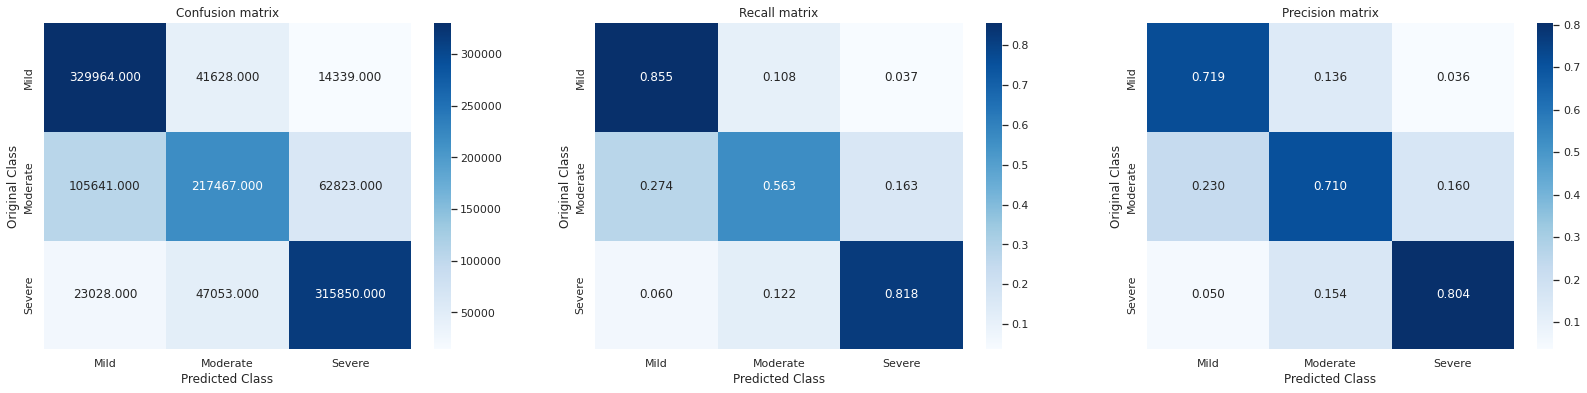


Confusion matrix on test data


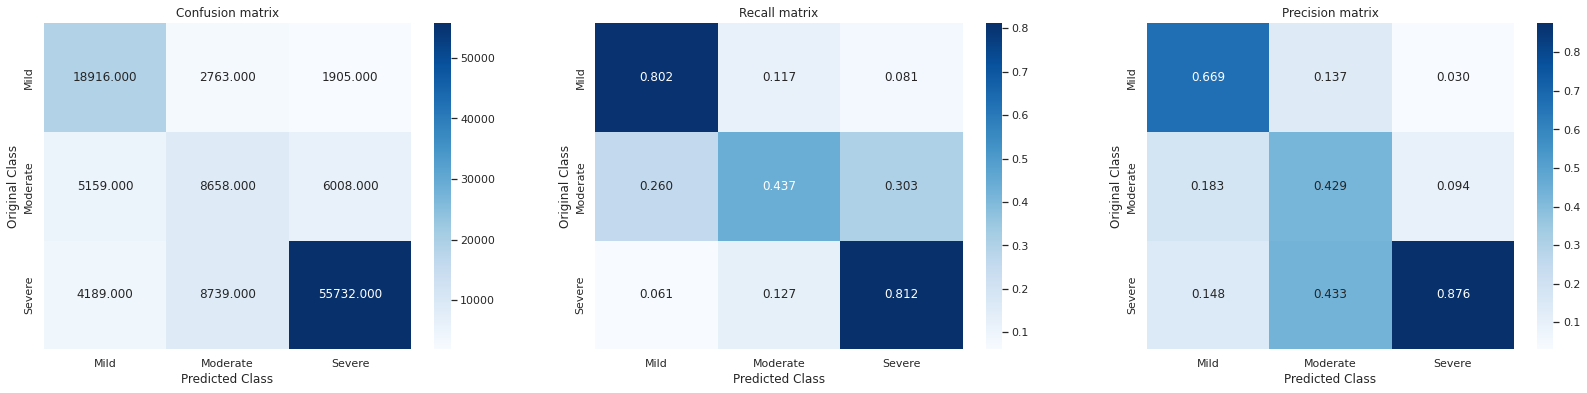


Classification report on train data
              precision    recall  f1-score   support

        mild       0.72      0.85      0.78    385931
    moderate       0.71      0.56      0.63    385931
      severe       0.80      0.82      0.81    385931

    accuracy                           0.75   1157793
   macro avg       0.74      0.75      0.74   1157793
weighted avg       0.74      0.75      0.74   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.67      0.80      0.73     23584
    moderate       0.43      0.44      0.43     19825
      severe       0.88      0.81      0.84     68660

    accuracy                           0.74    112069
   macro avg       0.66      0.68      0.67    112069
weighted avg       0.75      0.74      0.75    112069



In [ ]:
plot_results(y_tr_oversamp)

#### Undersamp model

In [ ]:
model = load_model(filepath+'models/model_ckpt/undersamp/model_weights-13-0.9253.h5')

In [ ]:
y_tr_pred = np.argmax(model.predict(X_tr_inputs), axis=1)
y_te_pred = np.argmax(model.predict(X_te_inputs),axis=1)

train_f1_score = round(f1_score(y_tr_undersamp, y_tr_pred, average='micro'), 4)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 4)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.7868
micro_f1_score on test data: 0.7689


Confusion matrix on train data


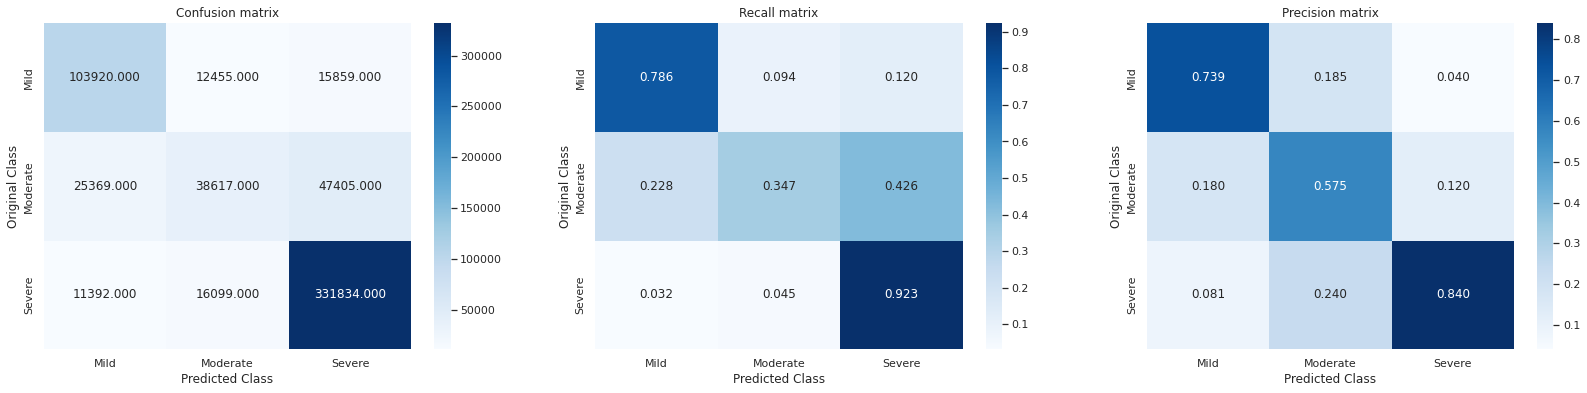


Confusion matrix on test data


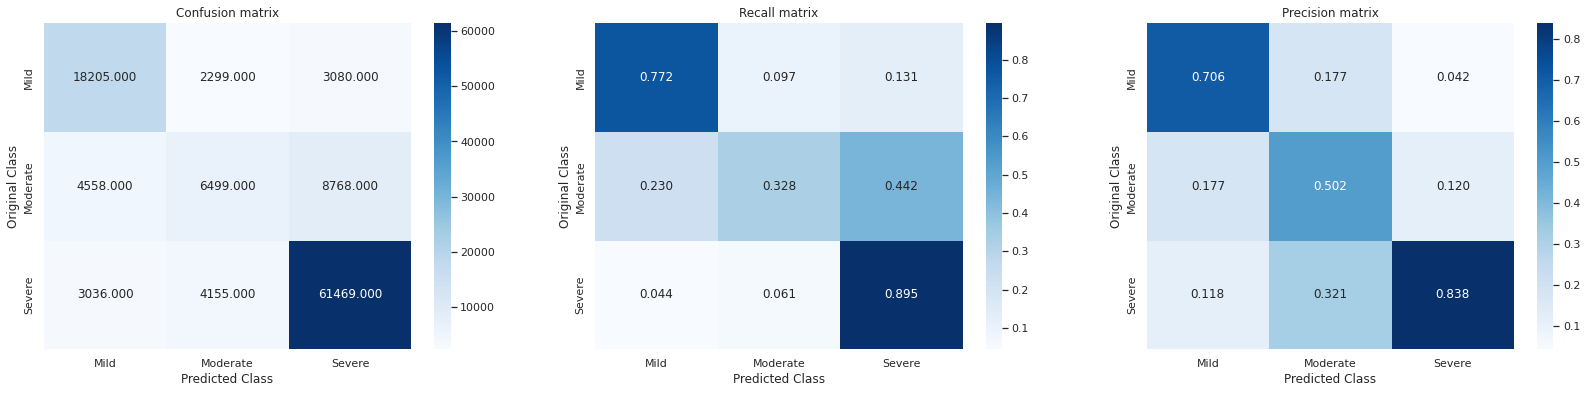


Classification report on train data
              precision    recall  f1-score   support

        mild       0.74      0.79      0.76    132234
    moderate       0.57      0.35      0.43    111391
      severe       0.84      0.92      0.88    359325

    accuracy                           0.79    602950
   macro avg       0.72      0.69      0.69    602950
weighted avg       0.77      0.79      0.77    602950


Classification report on test data
              precision    recall  f1-score   support

        mild       0.71      0.77      0.74     23584
    moderate       0.50      0.33      0.40     19825
      severe       0.84      0.90      0.87     68660

    accuracy                           0.77    112069
   macro avg       0.68      0.67      0.67    112069
weighted avg       0.75      0.77      0.76    112069



In [ ]:
plot_results(y_tr_undersamp)

#### Combsamp model

In [ ]:
model = load_model(filepath+'models/model_ckpt/combsamp/model_weights-07-0.7753.h5')

In [ ]:
y_tr_pred = np.argmax(model.predict(X_tr_inputs), axis=1)
y_te_pred = np.argmax(model.predict(X_te_inputs),axis=1)

train_f1_score = round(f1_score(y_tr_combsamp, y_tr_pred, average='micro'), 4)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 4)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.7282
micro_f1_score on test data: 0.7399


Confusion matrix on train data


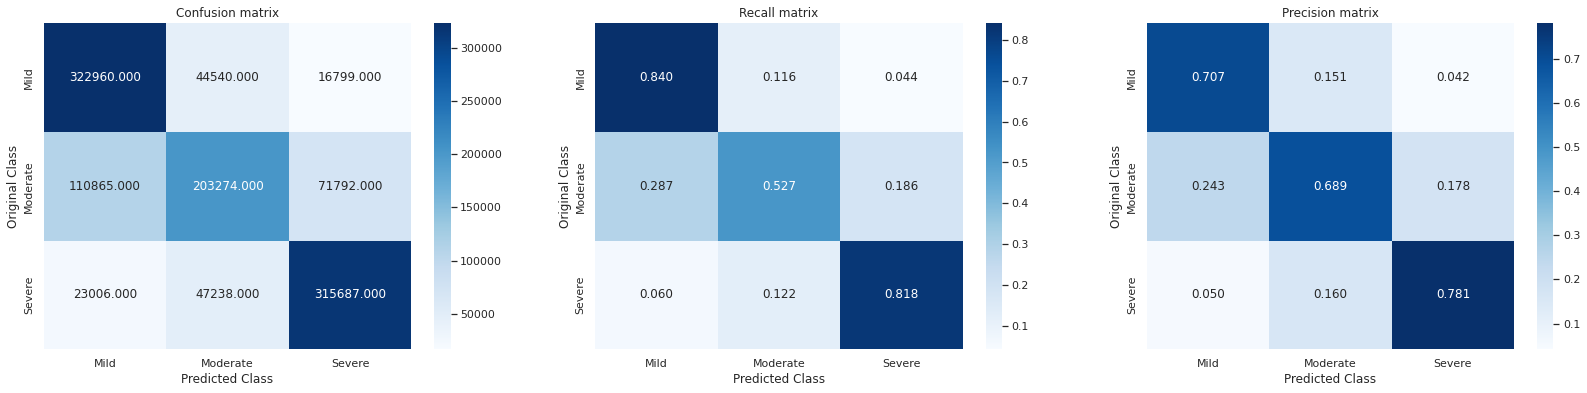


Confusion matrix on test data


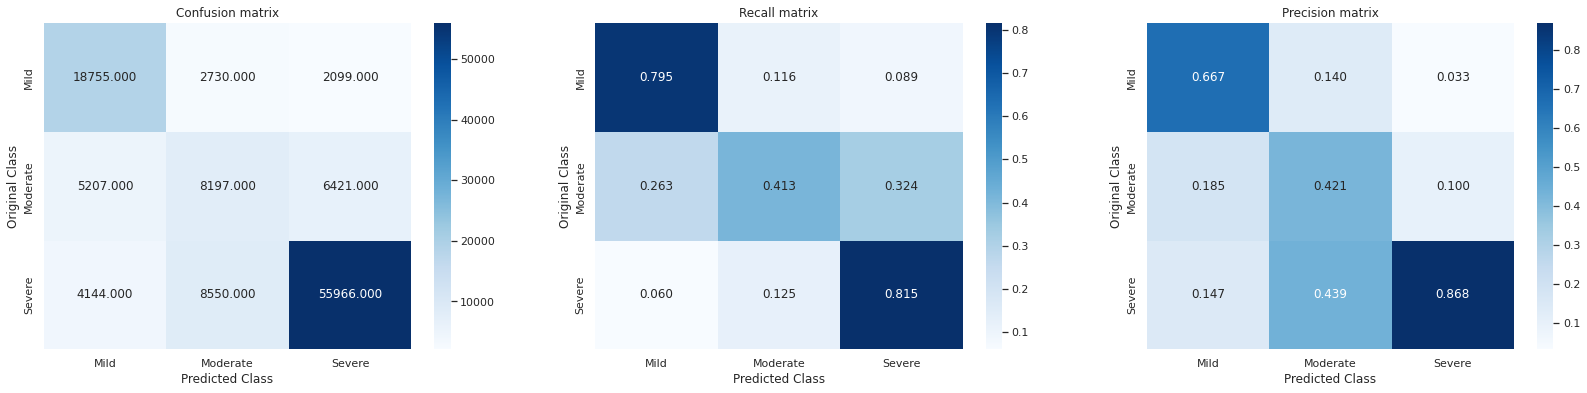


Classification report on train data
              precision    recall  f1-score   support

        mild       0.71      0.84      0.77    384299
    moderate       0.69      0.53      0.60    385931
      severe       0.78      0.82      0.80    385931

    accuracy                           0.73   1156161
   macro avg       0.73      0.73      0.72   1156161
weighted avg       0.73      0.73      0.72   1156161


Classification report on test data
              precision    recall  f1-score   support

        mild       0.67      0.80      0.73     23584
    moderate       0.42      0.41      0.42     19825
      severe       0.87      0.82      0.84     68660

    accuracy                           0.74    112069
   macro avg       0.65      0.67      0.66    112069
weighted avg       0.75      0.74      0.74    112069



In [ ]:
plot_results(y_tr_combsamp)

Observation:

1. Embedding model is performing better on undersampled data in terms of overall micro-f1 score
2. However, embedding model is performing slightly better on oversampled data for minority class 'Moderate' compared to that of undersampled data

So, we choose embedding model on oversampled data instead of undersampled or combined sampled data

### Get Embedded data

In [ ]:
embedding_matrix = get_embedding_matrix(model)
joblib.dump(embedding_matrix, filepath+'oversamp/embedding_matrix.pkl')

X_tr_emb, X_te_emb = get_embedded_data(embedding_matrix, X_tr_oversamp, X_test)

In [ ]:
# Dump embedded data
joblib.dump((X_tr_emb, y_tr_oversamp), filepath+ 'oversamp/embedded_train_data.pkl')
joblib.dump((X_te_emb, y_test), filepath+'oversamp/embedded_test_data.pkl')

['oversamp/embedded_test_data.pkl']

### Scaling the data

Standard scaling: Scaling the data such that each feature follow Gaussian distribution with mean at zero and 1 standard deviation.

Tried Normalizing the data between 0 and 1. However, standard scaling performed slightly better than normalizing.

In [ ]:
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_tr_emb)
X_te_std = scaler.transform(X_te_emb)

X_tr_std = pd.DataFrame(X_tr_std, columns=X_tr_emb.columns)
X_te_std = pd.DataFrame(X_te_std, columns=X_te_emb.columns)

joblib.dump(scaler, filepath+'oversamp/standard_scaler.pkl')

X_tr_std.head(2)

,district_id_0,district_id_1,district_id_2,district_id_3,district_id_4,district_id_5,vdcmun_id_0,vdcmun_id_1,vdcmun_id_2,vdcmun_id_3,...,has_asset_cable_pre_eq,has_asset_computer_pre_eq,has_asset_internet_pre_eq,has_asset_telephone_pre_eq,has_asset_mobile_phone_pre_eq,has_asset_fridge_pre_eq,has_asset_motorcycle_pre_eq,has_asset_four_wheeler_family_use_pre_eq,has_asset_four_wheeler_commercial_use_pre_eq,has_asset_none_pre_eq
0,0.661321,-1.551355,0.790370,-1.068915,-0.568114,-1.667955,0.513640,-1.789290,-0.674102,0.447573,...,-0.573521,-0.19574,-0.217781,-0.138691,0.455055,-0.221394,-0.227224,-0.040103,-0.064643,-0.067382
1,0.893890,1.378786,0.493645,-0.393644,0.593371,-0.086047,-0.129666,0.530346,-0.030029,1.887555,...,-0.573521,-0.19574,-0.217781,-0.138691,0.455055,-0.221394,-0.227224,-0.040103,-0.064643,-0.067382


In [ ]:
# Export the scaled data

# joblib.dump((X_tr_std, y_tr_oversamp), filepath+'oversamp/std_train_data.pkl')
# joblib.dump((X_te_std, y_test), filepath+'oversamp/std_test_data.pkl')